# EDA

## Data loading

In [21]:
from pathlib import Path
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
home_dir = Path().cwd()
dlr_dir = home_dir/"PROJECT_training2005"/"dlr_challenge"
data_dir = dlr_dir/"data"

In [3]:
fid = h5py.File(data_dir/"training.h5", 'r')

In [4]:
# load the data into memory. Careful! Training data is ~50GB
s1 = np.array(fid['sen1'])
s2 = np.array(fid['sen2'])
lab = np.array(fid['label'])

## Images

In [5]:
def print_sentinal_shape(s, name="Sentinal"):
    print(f"{name}: \n\t # Images:\t{s.shape[0]} \n\t Image shape:\t{s.shape[1:3]} \n\t # Channels:\t{s.shape[3]}")
    
print_sentinal_shape(s1, "Sentinal-1")
print_sentinal_shape(s2, "Sentinal-2")

Sentinal-1: 
	 # Images:	352366 
	 Image shape:	(32, 32) 
	 # Channels:	8
Sentinal-2: 
	 # Images:	352366 
	 Image shape:	(32, 32) 
	 # Channels:	10


## Labels

In [6]:
class_names = ("Compact high-rise", "Compact midrise", "Compact low-rise",
               "Open high-rise", "Open mid-rise", "Open low-rise",
              "Lightweight low-rise", "Large low-rise", "Soarsely built", "Heavy industry",
              "Dense trees", "Scattered trees", "Bush scrub", "Low plants", "Bare rock or paved",
              "Bare soil or sand", "Water")


In [7]:
lab_abs_freq = np.sum(lab, axis=0)
lab_rel_freq = lab_abs_freq/len(lab)

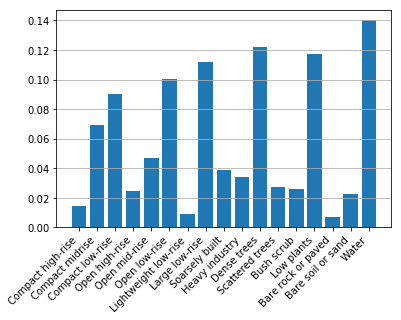

In [8]:
plt.bar(class_names, lab_rel_freq)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.show()

## PCA

In [9]:
from sklearn.decomposition import PCA
from keras.utils import normalize

Using TensorFlow backend.
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/p/software/jusuf/stages/Devel-2019a/software/TensorFlow/1.13.1-GCCcore-8.3.0-GPU-Python-3.6.8/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a syno

In [10]:
def flatten_images(x):
    """
    Input arraya of shape (N, W, H, C),
    where N is the number of images, W=Width, H=Height, C=Channels
    """
    n = x.shape[0]
    x = x.flatten()
    return x.reshape(n, np.int(len(x)/n))

In [11]:
def concat_sentinental(*s):
    """Stack channels on top of each other"""
    return np.concatenate(s, axis=-1)

In [12]:
# Maybe large memory required!
sentinentals = concat_sentinental(s1[:150], s2[:150])
subset_train, subset_val = sentinentals[:100], sentinentals[100:]

In [13]:
print(f"Test shape: {subset_train.shape} \nVal shape: {subset_val.shape}")

Test shape: (100, 32, 32, 18) 
Val shape: (50, 32, 32, 18)


Cumulative Explained Variance against number of components

In [14]:
pcas = [PCA(n_components=50).fit(flatten_images(subset_train[..., c])) 
        for c in range(subset_train.shape[-1])]

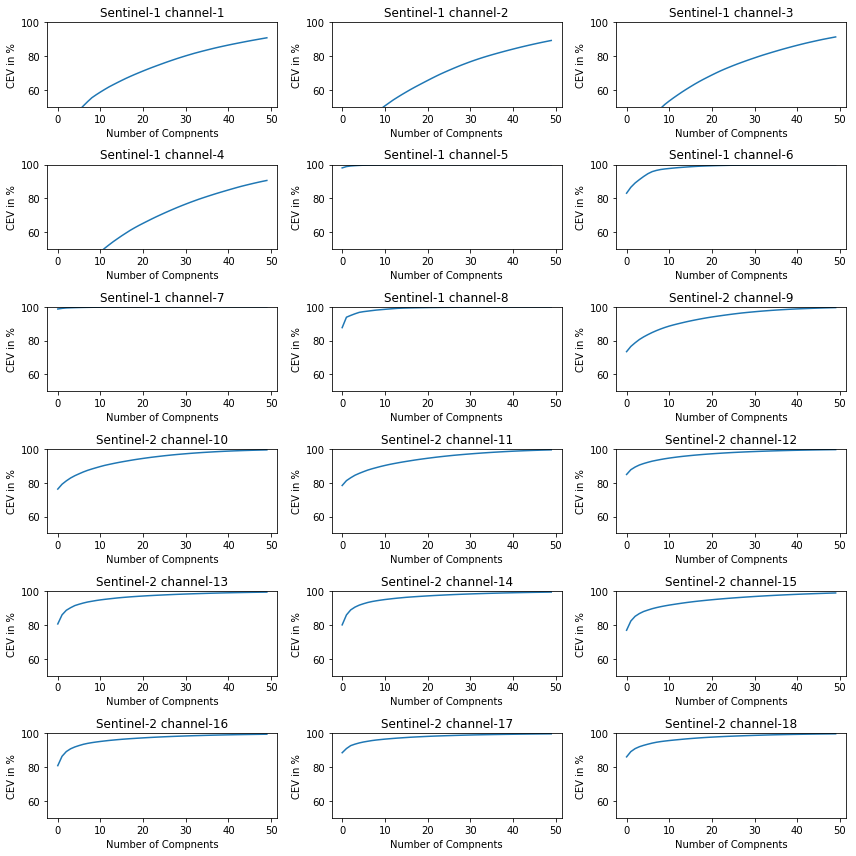

In [15]:
fig, axs = plt.subplots(nrows=6, ncols=3)
fig.set_size_inches(12, 12)
for i, pca in enumerate(pcas):
    s = "Sentinel-1" if i < 8 else "Sentinel-2"
    col = int(i % 3)
    row = int(i / 3)
    axs[row, col].set_title(f"{s} channel-{i+1}")
    axs[row, col].plot(np.cumsum(pca.explained_variance_ratio_)*100)
    axs[row, col].set_xlabel('Number of Compnents')
    axs[row, col].set_ylabel('CEV in %')
    axs[row, col].set_ylim(50, 100)
fig.tight_layout()

### Show mean image

Mean image for every channel

In [16]:
subset_train_mean = np.mean(subset_train, axis=0)

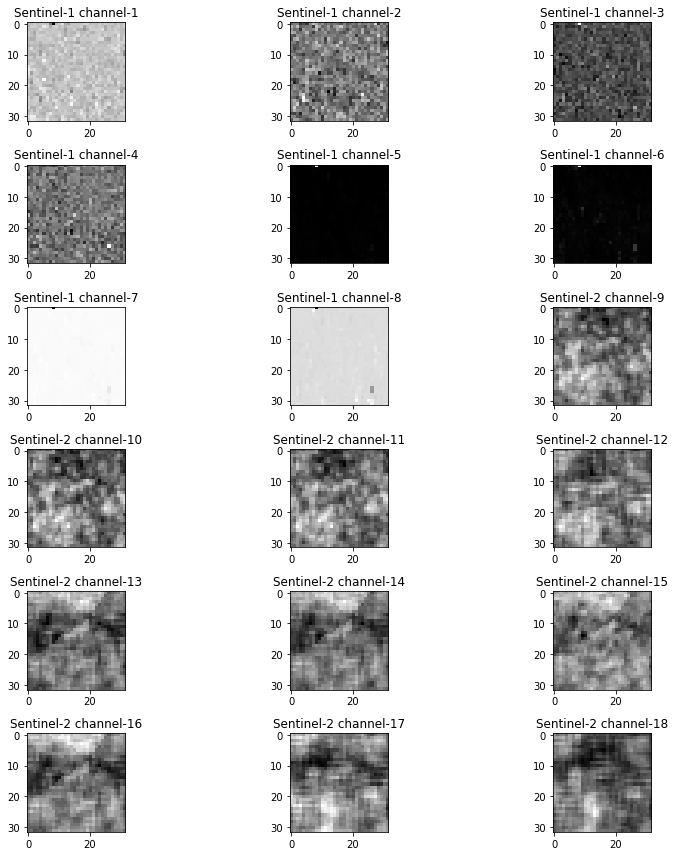

In [17]:
fig, axs = plt.subplots(nrows=6, ncols=3)
fig.set_size_inches(12, 12)
for i in range(subset_train_mean.shape[-1]):
    s = "Sentinel-1" if i < 8 else "Sentinel-2"
    col = int(i % 3)
    row = int(i / 3)
    axs[row, col].set_title(f"{s} channel-{i+1}")
    axs[row, col].imshow(subset_train_mean[..., i], cmap="gray")
fig.tight_layout()

In [18]:
fig.savefig(str(Path("./plots/mean_image_per_channel.png")), dpi=300)

### Clustering

Clustering capabilities on first two Principal Components

In [112]:
pcas_2 = [PCA(n_components=2).fit_transform(flatten_images(subset_train[..., c])) for c in range(n_channels)]

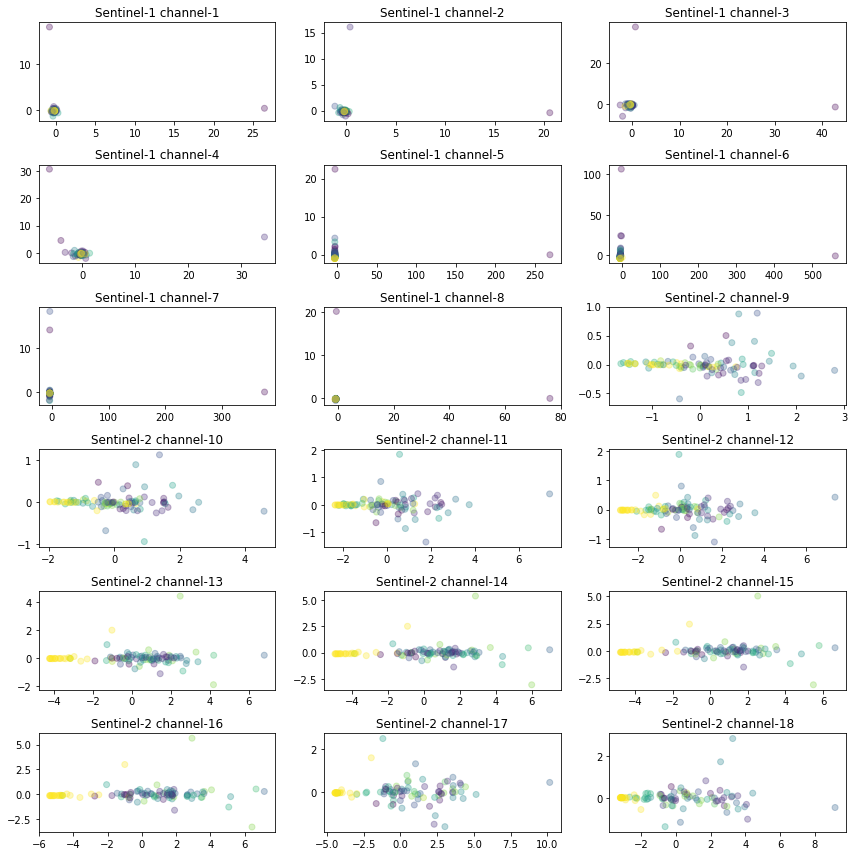

In [156]:
fig, axs = plt.subplots(nrows=6, ncols=3)
fig.set_size_inches(12, 12)
for i, sample in enumerate(pcas_2):
    s = "Sentinel-1" if i < 8 else "Sentinel-2"
    col = int(i % 3)
    row = int(i / 3)
    axs[row, col].set_title(f"{s} channel-{i+1}")
    axs[row, col].scatter(sample[:, 0], sample[:, 1], alpha=0.3, c=np.nonzero(lab[:100])[1], label=np.nonzero(lab[:100])[1])
fig.tight_layout()

In [157]:
fig.savefig(str(Path("./plots/clustered_images.png")), dpi=300)

### Autoencoder

In [ ]:
test_subset, val_subset = s1[:100, ...], s1[101:131, ...]
test_subset, val_subset = normalize(test_subset), normalize(val_subset)

In [94]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation

In [104]:
model = Sequential()
 
#1st convolution layer
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(32, 32, 8)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
 
#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
 
#here compressed version
 
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
 
#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))
 
model.add(Conv2D(8,(3, 3), padding='same'))
model.add(Activation('sigmoid', name="Sigmoid"))

In [105]:
model.compile(optimizer='adadelta', loss='mean_squared_error')
model.fit(test_subset, test_subset, epochs=20, validation_data=(val_subset, val_subset))

Train on 100 samples, validate on 30 samples
Epoch 1/20
100/100 [==============================] - 2s 18ms/step - loss: 0.3150 - val_loss: 0.2766
Epoch 2/20
100/100 [==============================] - 1s 5ms/step - loss: 0.2521 - val_loss: 0.1730
Epoch 3/20
100/100 [==============================] - 1s 6ms/step - loss: 0.1551 - val_loss: 0.1278
Epoch 4/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1266 - val_loss: 0.1222
Epoch 5/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1222 - val_loss: 0.1208
Epoch 6/20
100/100 [==============================] - 1s 7ms/step - loss: 0.1207 - val_loss: 0.1191
Epoch 7/20
100/100 [==============================] - 1s 8ms/step - loss: 0.1195 - val_loss: 0.1184
Epoch 8/20
100/100 [==============================] - 1s 5ms/step - loss: 0.1189 - val_loss: 0.1195
Epoch 9/20
100/100 [==============================] - 1s 6ms/step - loss: 0.1191 - val_loss: 0.1175
Epoch 10/20
100/100 [==============================] -

In [106]:
restored_imgs = model.predict(val_subset)

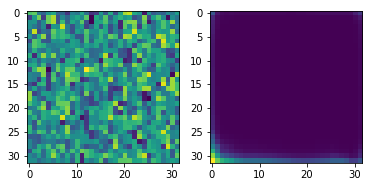

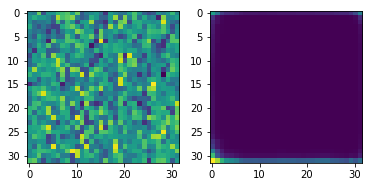

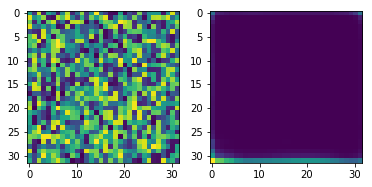

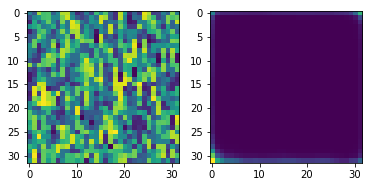

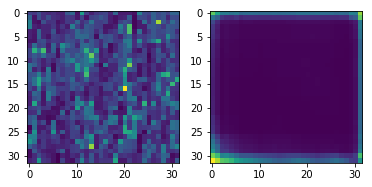

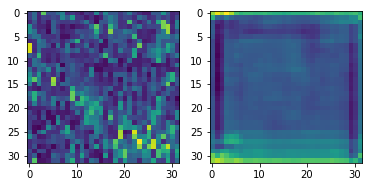

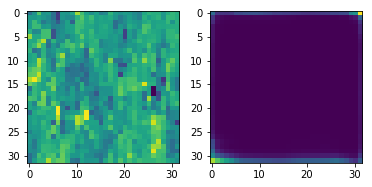

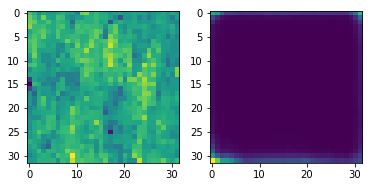

In [108]:
for i in range(8):
    plt.subplot(121)
    plt.imshow(val_subset[i, ..., i])
    plt.subplot(122)
    plt.imshow(restored_imgs[i, ..., i])
    plt.show()